In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow 
import tensorflow_hub as hub
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import LSTM, Bidirectional
from tensorflow.keras.layers import Dense, Flatten, MaxPooling1D, Input, Activation, add
from tensorflow.keras.models import Sequential, Model
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.layers import Dropout, BatchNormalization, Reshape
from sklearn.utils import resample
from sklearn.utils import shuffle
from tensorflow.keras import  optimizers
from tensorflow.keras.models import load_model


In [ ]:
tensorflow.__version__

#### load data

In [ ]:
data = pd.read_csv("agreed.csv", sep=",")
print(data.shape, data.columns)
features1 = data["title1_en"]
features2 = data["title2_en"]

#### generate embeddings using Google universal sentence encoder

In [ ]:
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")


In [ ]:
embedded_features1 = embed(features1)
embedded_features1 = np.array(embedded_features1)
result = pd.DataFrame(embedded_features1)
result.to_csv("features1.csv", index=False)


In [ ]:
embedded_features2 = embed(features2)
embedded_features2 = np.array(embedded_features2)
result = pd.DataFrame(embedded_features2)
result.to_csv("features2.csv", index=False)


In [ ]:
features1 = pd.read_csv("features1.csv")
features2 = pd.read_csv("features2.csv")
print(features1.shape, features2.shape)

(74238, 512) (74238, 512)


In [ ]:
processed = pd.concat([features1, features2], axis=1)


In [ ]:
print(processed.shape)


(74238, 1024)


In [ ]:
processed["mean"] = processed.mean(axis=1)

plt.hist(processed["mean"], 100)
plt.show()

In [ ]:
df_minority_upsampled = resample(processed, 
                                 replace=True,     # sample with replacement
                                 n_samples=75000,    # to match majority class
                                 random_state=123)

In [ ]:
df_minority_upsampled["mean"] = df_minority_upsampled.mean(axis=1)
plt.hist(df_minority_upsampled["mean"], 100)
plt.show()

In [ ]:
df_minority_upsampled.to_csv("agreed_downsample_75k.csv", index=False)

In [ ]:
cd drive/My\ Drive/MS/fall20/CS579/project2/100K_Data

/content/drive/My Drive/MS/fall20/CS579/project2/100K_Data


### Train on new data balanced

In [ ]:
agreed = pd.read_csv('agreed_downsample_75k.csv')
disagreed = pd.read_csv('disagreed_upsample_75k.csv')
unrealted = pd.read_csv('unrelated_downsample_75k.csv')


In [ ]:
agreed_data = agreed
unrealted_data = unrealted
disagreed_data = disagreed

In [ ]:
print(agreed_data, agreed_data.shape)

In [ ]:
labels = pd.DataFrame(["agreed"]*75000)
agreed_data["label"] = labels
agreed_data = agreed_data.drop("mean", 1)
a_shuffle = shuffle(agreed_data)
print(a_shuffle, a_shuffle.shape)
# labels = pd.DataFrame(["disagreed"]*75000)
# disagreed = pd.concat([disagreed, labels], axis=1)
# labels = pd.DataFrame(["unrelated"]*75000)
# unrealted = pd.concat([unrealted, labels], axis=1)
# print(agreed.shape, disagreed.shape, unrealted.shape)


In [ ]:
labels = pd.DataFrame(["disagreed"]*75000)
disagreed_data["label"] = labels
disagreed_data = disagreed_data.drop("mean", 1)
dis_shuffle = shuffle(disagreed_data)
print(dis_shuffle, dis_shuffle.shape)

In [ ]:
labels = pd.DataFrame(["unrelated"]*75000)
unrealted_data["label"] = labels
unrealted_data = unrealted_data.drop("mean", 1)
u_shuffle = shuffle(unrealted_data)
print(u_shuffle, u_shuffle.shape)

In [ ]:
final_data = pd.concat([agreed_data, disagreed_data, unrealted_data], axis=0)
print(final_data.shape, final_data)

In [ ]:
final_data = shuffle(final_data)
print(final_data)
final_data.to_csv("final_data_merged.csv", index=False)

In [ ]:
final_data = pd.read_csv("final_data_merged.csv")

In [ ]:
final_data = pd.read_csv("final_data_new_merged.csv")

In [ ]:
train = pd.read_csv("Merged_Train_OG.csv")
val = pd.read_csv("Merged_Val_OG.csv")

In [ ]:
train.shape, val.shape

((205154, 1025), (51288, 1025))

In [ ]:
features = final_data.iloc[:, :1025]
labels = final_data.iloc[:, 1025:1026]
print(features.shape, labels.shape)

(300000, 1025) (300000, 1)


In [ ]:
train_x = train.iloc[:, :1024]
train_y = train.iloc[:, 1024:1025]
val_x = val.iloc[:, :1024]
val_y = val.iloc[:, 1024:1025]
print(train_x.shape, train_y.shape)

In [ ]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

In [ ]:
encoder = LabelEncoder()
encoder.fit(labels)
labels = encoder.transform(labels)
labels = to_categorical(labels)

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
encoder = LabelEncoder()
encoder.fit(train_y)
train_y = encoder.transform(train_y)
train_y = to_categorical(train_y)

encoder = LabelEncoder()
encoder.fit(val_y)
val_y = encoder.transform(val_y)
val_y = to_categorical(val_y)

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
val_x = np.array(features[:10000])
val_y = labels[:10000]

train_x = np.array(features[10000:])
train_y = labels[10000:]

#### Full connected

In [ ]:
model = Sequential()

model.add(Dense(units=256, activation='relu'))
model.add(Dropout(0.3))
model.add(BatchNormalization())

model.add(Dense(units=128, activation='relu'))
model.add(Dropout(0.3))
model.add(BatchNormalization())

model.add(Dense(units=64,activation='relu'))
model.add(Dropout(0.3))
model.add(BatchNormalization())

model.add(Dense(units=32, activation='relu'))
model.add(Dense(3, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])

In [ ]:
model.build(input_shape=(None, 1024))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 256)               262400    
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)               0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 256)               1024      
_________________________________________________________________
dense_6 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_4 (Dropout)          (None, 128)               0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 128)               512       
_________________________________________________________________
dense_7 (Dense)              (None, 64)               

In [ ]:
from tensorflow import keras

#### LSTM

In [ ]:
model = Sequential()
model.add(LSTM(units=256, return_sequences=True, kernel_initializer='he_normal'))
model.add(Dropout(0.3))
model.add(BatchNormalization())
model.add(LSTM(units=256, return_sequences=True, go_backwards=True, kernel_initializer='he_normal'))
model.add(Dropout(0.3))
model.add(BatchNormalization())
model.add(LSTM(units=128, kernel_initializer='he_normal'))
model.add(Dense(3, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])

#### Bi-LSTM

In [ ]:
model = Sequential()
model.add(Bidirectional(LSTM(units=512, return_sequences=True, kernel_initializer='he_normal')))
model.add(Dropout(0.5))
model.add(BatchNormalization())
model.add(Bidirectional(LSTM(units=512, return_sequences=True, go_backwards=True, kernel_initializer='he_normal')))
model.add(Dropout(0.3))
# model.add(Bidirectional(LSTM(units=256, return_sequences=True, go_backwards=True, kernel_initializer='he_normal')))
# model.add(Dropout(0.3))
# model.add(BatchNormalization())
# model.add(Bidirectional(LSTM(units=256, kernel_initializer='he_normal')))
# model.add(Dropout(0.5))
# model.add(BatchNormalization())
# model.add(Flatten())
model.add(Dense(128, activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(128, activation="relu"))
model.add(Dense(3, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])

In [ ]:
model.build(input_shape=(None,1, 1024))
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional multiple                  6295552   
_________________________________________________________________
dropout_6 (Dropout)          multiple                  0         
_________________________________________________________________
batch_normalization_6 (Batch multiple                  4096      
_________________________________________________________________
bidirectional_1 (Bidirection multiple                  6295552   
_________________________________________________________________
dropout_7 (Dropout)          multiple                  0         
_________________________________________________________________
dense_10 (Dense)             multiple                  131200    
_________________________________________________________________
dropout_8 (Dropout)          multiple                 

#### CNN + Dense

In [ ]:
model = Sequential()
model.add(Conv1D(filters=256, kernel_size=1, padding='same', activation='relu', kernel_initializer='he_normal',input_shape=(1, 1024)))
model.add(MaxPooling1D(pool_size=1))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Conv1D(filters=512, kernel_size=1, padding='same', activation='relu', kernel_initializer='he_normal',input_shape=(1, 1024)))
model.add(MaxPooling1D(pool_size=1))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Conv1D(filters=256, kernel_size=1, padding='same', activation='relu', kernel_initializer='he_normal',input_shape=(1, 1024)))
model.add(MaxPooling1D(pool_size=1))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(128, activation="relu"))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(128, activation="relu"))
model.add(Dense(3, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])

In [ ]:
model.build(input_shape=(None,1, 1024))
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 1, 256)            262400    
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 1, 256)            0         
_________________________________________________________________
batch_normalization_7 (Batch (None, 1, 256)            1024      
_________________________________________________________________
dropout_9 (Dropout)          (None, 1, 256)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1, 512)            131584    
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 1, 512)            0         
_________________________________________________________________
batch_normalization_8 (Batch (None, 1, 512)           

### TALOS Network

In [ ]:
model = Sequential()
model.add(Conv1D(filters=256, kernel_size=1, padding='same', activation='relu', kernel_initializer='he_normal',input_shape=(1, 1024)))
# model.add(MaxPooling1D(pool_size=1))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Conv1D(filters=256, kernel_size=1, padding='same', activation='relu', kernel_initializer='he_normal',input_shape=(1, 1024)))
# model.add(MaxPooling1D(pool_size=1))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Conv1D(filters=512, kernel_size=1, padding='same', activation='relu', kernel_initializer='he_normal',input_shape=(1, 1024)))
# model.add(MaxPooling1D(pool_size=1))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Conv1D(filters=512, kernel_size=1, padding='same', activation='relu', kernel_initializer='he_normal',input_shape=(1, 1024)))
# model.add(MaxPooling1D(pool_size=1))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Conv1D(filters=768, kernel_size=1, padding='same', activation='relu', kernel_initializer='he_normal',input_shape=(1, 1024)))
# model.add(MaxPooling1D(pool_size=1))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(1024, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(1024, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])

### ResNet

In [ ]:
  
x = Input(shape=(None,  1024))
y = Conv1D(256, 1, activation="relu")(x)
y = BatchNormalization()(y)
y = MaxPooling1D(1)(y)

y = Conv1D(256, 1, activation="relu")(y)
y = BatchNormalization()(y)
y = Dropout(0.5)(y)
y = MaxPooling1D(1)(y)

y = Conv1D(512, 1, activation="relu")(y)
y = BatchNormalization()(y)
y = Dropout(0.5)(y)
y = MaxPooling1D(1)(y)


y = Conv1D(128, 1, activation="relu")(y)
y = BatchNormalization()(y)
y = Dropout(0.5)(y)

residual = Dense(128, activation="relu")(x)

y = add([y, residual])

out = Dense(3, activation='softmax')(y)

model = Model(inputs=x, outputs=out)
model.summary()
sgd = optimizers.SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [ ]:
tensorflow.config.run_functions_eagerly(True)

In [ ]:
train_x = np.array(train_x).reshape((train_x.shape[0],1, train_x.shape[1]))
train_y = np.array(train_y).reshape((train_y.shape[0],1, train_y.shape[1]))


In [ ]:
val_x = np.array(val_x).reshape((val_x.shape[0],1, val_x.shape[1]))
val_y = val_y.reshape((val_y.shape[0],1, val_y.shape[1]))

In [ ]:
val_y.shape, train_y.shape

((10000, 1, 62), (290000, 1, 62))

In [ ]:
model.summary()

In [ ]:
history = model.fit(train_x, train_y, epochs=10, validation_data = (val_x, val_y), batch_size=256)
history = history.history

/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "


Epoch 1/10
1133/1133 [==============================] - 54s 48ms/step - loss: 0.5956 - accuracy: 0.7081 - val_loss: 0.4217 - val_accuracy: 0.7982
Epoch 2/10
1133/1133 [==============================] - 54s 48ms/step - loss: 0.4205 - accuracy: 0.8090 - val_loss: 0.3270 - val_accuracy: 0.8528
Epoch 3/10
1133/1133 [==============================] - 52s 46ms/step - loss: 0.3542 - accuracy: 0.8433 - val_loss: 0.2966 - val_accuracy: 0.8699
Epoch 4/10
1133/1133 [==============================] - 52s 46ms/step - loss: 0.3156 - accuracy: 0.8626 - val_loss: 0.2712 - val_accuracy: 0.8842
Epoch 5/10
1133/1133 [==============================] - 52s 46ms/step - loss: 0.2838 - accuracy: 0.8787 - val_loss: 0.2542 - val_accuracy: 0.8932
Epoch 6/10
1133/1133 [==============================] - 54s 48ms/step - loss: 0.2631 - accuracy: 0.8887 - val_loss: 0.2349 - val_accuracy: 0.9035
Epoch 7/10
1133/1133 [==============================] - 54s 47ms/step - loss: 0.2427 - accuracy: 0.8984 - val_loss: 0.2301 -

In [ ]:
history

In [ ]:
model.save("simple-feed-forward")

In [ ]:
model = load_model("talos_network")

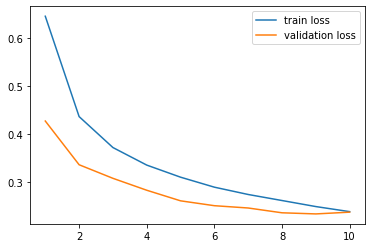

In [ ]:

train_loss = history["loss"]
val_loss = history["val_loss"]
epochs = range(1, len(train_loss)+1)

plt.plot(epochs, train_loss, label="train loss")
plt.plot(epochs, val_loss, label="validation loss")
plt.legend()
plt.show()

In [ ]:
train_loss = history["accuracy"]
val_loss = history["val_accuracy"]
epochs = range(1, len(train_loss)+1)

plt.plot(epochs, train_loss, label="train acc")
plt.plot(epochs, val_loss, label="validation acc")
plt.legend()
plt.show()